In [21]:
import pandas as pd

test_df = pd.read_csv('/kaggle/input/frozen-preds/test_df (1).csv')

In [22]:
import pandas as pd

deberta_preds = pd.read_csv('/kaggle/input/second-ai-predictions/predictions_deberta-v3-large.csv')
second_deberta_preds = pd.read_csv('/kaggle/input/frozen-preds/predictions_deberta-v3-large.csv')
roberta_preds = pd.read_csv('/kaggle/input/second-ai-predictions/predictions_roberta-base-openai-detector.csv')
xlm_preds = pd.read_csv('/kaggle/input/second-ai-predictions/predictions_xlm-roberta-large-xnli-anli.csv')
xlm_roberta_preds = pd.read_csv('/kaggle/input/second-ai-predictions/predictions_xlm-roberta-large.csv')

bert_multi_preds = pd.read_csv('/kaggle/input/new-model-preds/predictions_bert-base-multilingual-cased.csv')
vicuna_preds = pd.read_csv('/kaggle/input/new-model-preds/predictions_RADAR-Vicuna-7B.csv')
long_preds = pd.read_csv('/kaggle/input/new-model-preds/predictions_longformer-base-4096.csv')

In [23]:
second_deberta_preds.rename(columns={
    'p0_deberta-v3-large': 'p0_deberta-v3-large-frozen',
    'p1_deberta-v3-large': 'p1_deberta-v3-large-frozen'
}, inplace=True)


In [24]:
data = pd.concat([deberta_preds,second_deberta_preds,long_preds,vicuna_preds],axis=1)

In [25]:
data['label'] = test_df['label']

In [26]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calculate various metrics for model evaluation"""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_macro': f1
    }

def plot_confusion_matrix(y_true, y_pred, labels=None, model_name="Model"):
    """Plot confusion matrix using seaborn"""
    cm = confusion_matrix(y_true, y_pred)  # Ensure conversion to array
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels if labels is not None else 'auto',
                yticklabels=labels if labels is not None else 'auto')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Create the individual base models
base_models = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('lgb', LGBMClassifier(random_state=42, verbose=-1)),
    ('catboost', CatBoostClassifier(random_state=42, verbose=0)),
    ('nb', GaussianNB()),
    ('svc', SVC()),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('mlp', MLPClassifier(random_state=42))
]

class EnsembleExperiments:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)
        
        # For models that benefit from scaling
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        # Store results for comparison
        self.results = {}
    
    def run_all_experiments(self):
        """Run all ensemble experiments and compare results"""
        self.train_base_models()
        self.train_voting_classifier()
        self.train_weighted_voting_classifier()
        self.train_soft_voting_classifier()
        self.train_stacking_classifier()
        self.train_advanced_stacking()
        self.train_bagging_classifier()
        self.train_boosting_models()
        self.train_custom_ensemble()
        self.compare_results()
    
    def train_base_models(self):
        """Train and evaluate individual base models"""
        for name, model in base_models:
            print(f"Training {name}...")
            try:
                # Use scaled data for models that benefit from it
                if name in ['lr', 'svc', 'knn', 'mlp']:
                    model.fit(self.X_train_scaled, self.y_train)
                    y_pred = model.predict(self.X_test_scaled)
                else:
                    model.fit(self.X_train, self.y_train)
                    y_pred = model.predict(self.X_test)
                
                metrics = evaluate_model(self.y_test, y_pred, name)
                self.results[name] = metrics
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
    
    def train_voting_classifier(self):
        """Train and evaluate hard voting classifier"""
        # Use only models that don't require probability estimates for hard voting
        voting_models = [model for model in base_models if model[0] not in ['svc']]
        
        voting_clf = VotingClassifier(estimators=voting_models, voting='hard')
        voting_clf.fit(self.X_train, self.y_train)
        y_pred = voting_clf.predict(self.X_test)
        
        metrics = evaluate_model(self.y_test, y_pred, "Hard Voting Classifier")
        plot_confusion_matrix(self.y_test, y_pred, model_name="Hard Voting")
        self.results['hard_voting'] = metrics
    
    def train_weighted_voting_classifier(self):
        """Train and evaluate weighted voting classifier"""
        # Define weights based on individual model performance
        # Higher weights for better performing models
        weighted_models = [model for model in base_models if model[0] not in ['svc']]
        
        weights = [0.5, 0.8, 0.8, 0.7, 0.7, 0.4, 0.6, 0.5]  # Example weights matching the filtered models
        
        weighted_voting = VotingClassifier(
            estimators=weighted_models,
            voting='hard', 
            #weights=weights
        )
        
        weighted_voting.fit(self.X_train, self.y_train)
        y_pred = weighted_voting.predict(self.X_test)
        
        metrics = evaluate_model(self.y_test, y_pred, "Weighted Voting Classifier")
        plot_confusion_matrix(self.y_test, y_pred, model_name="Weighted Voting")
        self.results['weighted_voting'] = metrics
    
    def train_soft_voting_classifier(self):
        """Train and evaluate soft voting classifier"""
        # Use only models that can predict probabilities
        soft_models = [
            ('lr', LogisticRegression(max_iter=1000)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('xgb', XGBClassifier(n_estimators=100, random_state=42)),
            ('lgb', LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)),
            ('nb', GaussianNB()),
            ('svc', SVC(probability=True)),  # Enable probability
            ('knn', KNeighborsClassifier(n_neighbors=5)),
            ('dt', DecisionTreeClassifier(random_state=42))
        ]
        
        soft_voting = VotingClassifier(
            estimators=soft_models,
            voting='soft'
        )
        
        soft_voting.fit(self.X_train, self.y_train)
        y_pred = soft_voting.predict(self.X_test)
        
        metrics = evaluate_model(self.y_test, y_pred, "Soft Voting Classifier")
        plot_confusion_matrix(self.y_test, y_pred, model_name="Soft Voting")
        self.results['soft_voting'] = metrics
    
    def train_stacking_classifier(self):
        """Train and evaluate basic stacking classifier"""
        # First level estimators
        estimators = [
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('xgb', XGBClassifier(n_estimators=100, random_state=42)),
            ('lgb', LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)),
            ('dt', DecisionTreeClassifier(random_state=42))
        ]
        
        # Final estimator
        final_estimator = LogisticRegression(max_iter=1000)
        
        # Create stacking classifier
        stacking_clf = StackingClassifier(
            estimators=estimators,
            final_estimator=final_estimator,
            cv=5  # 5-fold cross-validation
        )
        
        stacking_clf.fit(self.X_train, self.y_train)
        y_pred = stacking_clf.predict(self.X_test)
        
        metrics = evaluate_model(self.y_test, y_pred, "Basic Stacking Classifier")
        plot_confusion_matrix(self.y_test, y_pred, model_name="Basic Stacking")
        self.results['basic_stacking'] = metrics
    
    def train_advanced_stacking(self):
        """Train and evaluate advanced stacking with meta-features"""
        # First level estimators
        estimators = [
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('xgb', XGBClassifier(n_estimators=100, random_state=42)),
            ('lgb', LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)),
            ('catboost', CatBoostClassifier(n_estimators=100, random_state=42, verbose=0))
        ]
        
        # Final estimator (meta-learner)
        # Using a more complex meta-learner
        final_estimator = GradientBoostingClassifier(n_estimators=100, random_state=42)
        
        # Create advanced stacking classifier
        stacking_clf = StackingClassifier(
            estimators=estimators,
            final_estimator=final_estimator,
            cv=5,  # 5-fold cross-validation
            stack_method='predict_proba',  # Use probability predictions
            passthrough=True  # Include original features
        )
        
        stacking_clf.fit(self.X_train, self.y_train)
        y_pred = stacking_clf.predict(self.X_test)
        
        metrics = evaluate_model(self.y_test, y_pred, "Advanced Stacking Classifier")
        plot_confusion_matrix(self.y_test, y_pred, model_name="Advanced Stacking")
        self.results['advanced_stacking'] = metrics
    
    def train_bagging_classifier(self):
        """Train and evaluate various bagging classifiers"""
        # 1. Basic Bagging with Decision Tree
        base_dt = DecisionTreeClassifier(random_state=42)
        bagging_dt = BaggingClassifier(
            base_estimator=base_dt,
            n_estimators=100,
            max_samples=0.8,  # Use 80% of samples
            max_features=0.8,  # Use 80% of features
            bootstrap=True,    # Sample with replacement
            bootstrap_features=True,
            random_state=42
        )
        
        bagging_dt.fit(self.X_train, self.y_train)
        y_pred = bagging_dt.predict(self.X_test)
        
        metrics = evaluate_model(self.y_test, y_pred, "Bagging with Decision Tree")
        plot_confusion_matrix(self.y_test, y_pred, model_name="Bagging (DT)")
        self.results['bagging_dt'] = metrics
        
        # 2. Bagging with SVC
        base_svc = SVC(probability=True)
        bagging_svc = BaggingClassifier(
            base_estimator=base_svc,
            n_estimators=50,  # Fewer estimators due to SVC complexity
            max_samples=0.8,
            bootstrap=True,
            random_state=42
        )
        
        bagging_svc.fit(self.X_train_scaled, self.y_train)  # Using scaled data for SVC
        y_pred = bagging_svc.predict(self.X_test_scaled)
        
        metrics = evaluate_model(self.y_test, y_pred, "Bagging with SVC")
        plot_confusion_matrix(self.y_test, y_pred, model_name="Bagging (SVC)")
        self.results['bagging_svc'] = metrics
    
    def train_boosting_models(self):
        """Train and evaluate boosting-based models"""
        # 1. AdaBoost with Decision Tree
        ada_boost = AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(),
            random_state=42
        )
        
        ada_boost.fit(self.X_train, self.y_train)
        y_pred = ada_boost.predict(self.X_test)
        
        metrics = evaluate_model(self.y_test, y_pred, "AdaBoost Classifier")
        plot_confusion_matrix(self.y_test, y_pred, model_name="AdaBoost")
        self.results['adaboost'] = metrics
        
        # 2. Gradient Boosting
        gb_clf = GradientBoostingClassifier(
            random_state=42
        )
        
        gb_clf.fit(self.X_train, self.y_train)
        y_pred = gb_clf.predict(self.X_test)
        
        metrics = evaluate_model(self.y_test, y_pred, "Gradient Boosting Classifier")
        plot_confusion_matrix(self.y_test, y_pred, model_name="Gradient Boosting")
        self.results['gradient_boosting'] = metrics
    
    def train_custom_ensemble(self):
        """Implement a custom ensemble that uses both hard and soft voting concepts"""
        # First level models
        models = [
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('xgb', XGBClassifier(n_estimators=100, random_state=42)),
            ('lgb', LGBMClassifier(n_estimators=100, random_state=42, verbose=-1))
        ]
        
        # Train first level models and collect predictions
        first_level_preds = np.zeros((self.X_test.shape[0], len(models)))
        
        for i, (name, model) in enumerate(models):
            print(f"Training {name} for custom ensemble...")
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)
            first_level_preds[:, i] = y_pred
        
        # Apply a simple weighted average rule for the final prediction
        # Get weights based on cross-validation performance
        weights = np.zeros(len(models))
        for i, (name, model) in enumerate(models):
            cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5)
            weights[i] = np.mean(cv_scores)
        
        # Normalize weights
        weights = weights / np.sum(weights)
        print(f"Model weights for custom ensemble: {weights}")
        
        # Apply weighted voting
        weighted_preds = np.zeros(self.X_test.shape[0])
        for i in range(len(models)):
            weighted_preds += weights[i] * first_level_preds[:, i]
        
        # Round to get final predictions
        final_preds = np.round(weighted_preds).astype(int)
        
        metrics = evaluate_model(self.y_test, final_preds, "Custom Ensemble Classifier")
        plot_confusion_matrix(self.y_test, final_preds, model_name="Custom Ensemble")
        self.results['custom_ensemble'] = metrics
    
    def compare_results(self):
        """Compare and visualize results from all models"""
        # Create a DataFrame from the results
        results_df = pd.DataFrame(self.results).T
        
        # Sort by accuracy
        results_df = results_df.sort_values(by='accuracy', ascending=False)
        
        # Display results
        print("\n=== Model Comparison ===")
        print(results_df)
        
        # Plot accuracy comparison
        plt.figure(figsize=(12, 6))
        results_df['accuracy'].plot(kind='bar', color='skyblue')
        plt.title('Model Accuracy Comparison')
        plt.xlabel('Model')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Plot F1 score comparison
        plt.figure(figsize=(12, 6))
        results_df['f1_macro'].plot(kind='bar', color='lightgreen')
        plt.title('Model F1 Score Comparison')
        plt.xlabel('Model')
        plt.ylabel('F1 Score (Macro)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Return the best model and its performance
        best_model = results_df.index[0]
        best_performance = results_df.iloc[0]
        
        print(f"\nBest performing model: {best_model}")
        print(f"Best model performance: {best_performance}")
        
        return best_model, best_performance

Training lr...

lr Performance Metrics:
Accuracy: 0.8600
Precision: 0.8620
Recall: 0.8594
F1 Score: 0.8596
Training rf...

rf Performance Metrics:
Accuracy: 0.8250
Precision: 0.8269
Recall: 0.8256
F1 Score: 0.8249
Training xgb...

xgb Performance Metrics:
Accuracy: 0.8175
Precision: 0.8180
Recall: 0.8178
F1 Score: 0.8175
Training lgb...

lgb Performance Metrics:
Accuracy: 0.8250
Precision: 0.8269
Recall: 0.8256
F1 Score: 0.8249
Training catboost...

catboost Performance Metrics:
Accuracy: 0.8400
Precision: 0.8407
Recall: 0.8403
F1 Score: 0.8400
Training nb...

nb Performance Metrics:
Accuracy: 0.8750
Precision: 0.8750
Recall: 0.8750
F1 Score: 0.8750
Training svc...

svc Performance Metrics:
Accuracy: 0.8700
Precision: 0.8700
Recall: 0.8700
F1 Score: 0.8700
Training knn...

knn Performance Metrics:
Accuracy: 0.8650
Precision: 0.8650
Recall: 0.8650
F1 Score: 0.8650
Training dt...

dt Performance Metrics:
Accuracy: 0.8125
Precision: 0.8133
Recall: 0.8129
F1 Score: 0.8125
Training mlp...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



mlp Performance Metrics:
Accuracy: 0.8750
Precision: 0.8750
Recall: 0.8750
F1 Score: 0.8750


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Hard Voting Classifier Performance Metrics:
Accuracy: 0.8525
Precision: 0.8530
Recall: 0.8528
F1 Score: 0.8525


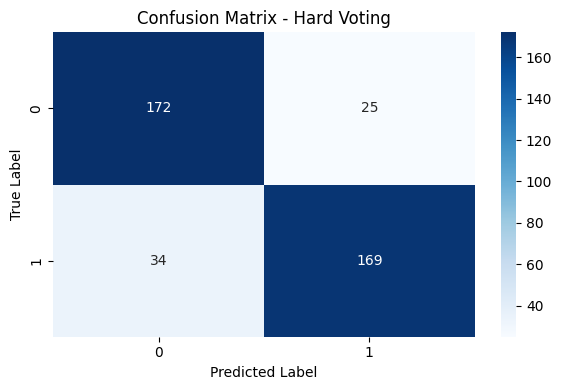

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Weighted Voting Classifier Performance Metrics:
Accuracy: 0.8525
Precision: 0.8530
Recall: 0.8528
F1 Score: 0.8525


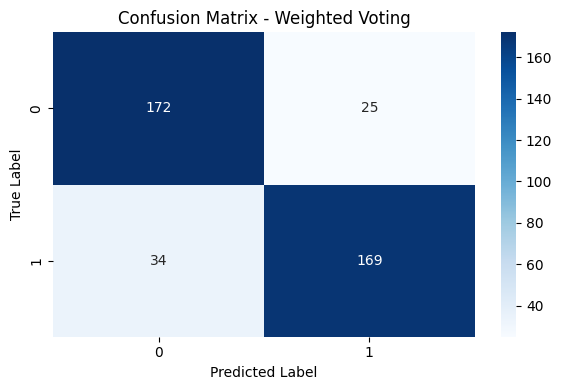


Soft Voting Classifier Performance Metrics:
Accuracy: 0.8550
Precision: 0.8552
Recall: 0.8552
F1 Score: 0.8550


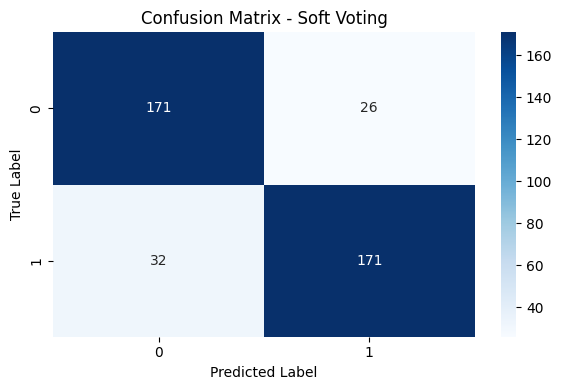


Basic Stacking Classifier Performance Metrics:
Accuracy: 0.8275
Precision: 0.8287
Recall: 0.8279
F1 Score: 0.8274


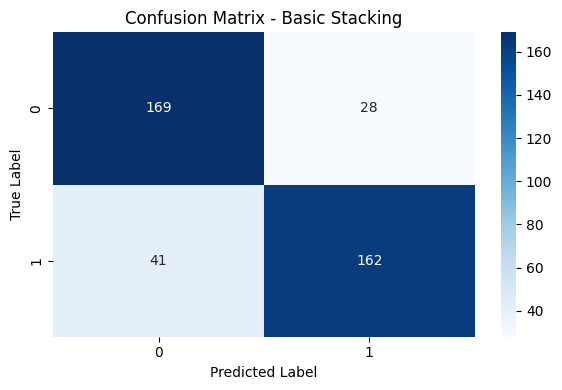


Advanced Stacking Classifier Performance Metrics:
Accuracy: 0.8650
Precision: 0.8654
Recall: 0.8653
F1 Score: 0.8650


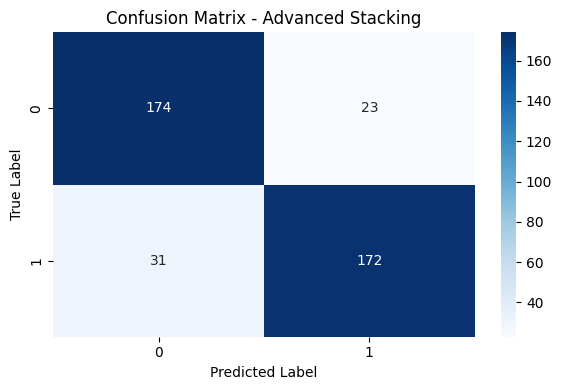

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Bagging with Decision Tree Performance Metrics:
Accuracy: 0.8400
Precision: 0.8414
Recall: 0.8405
F1 Score: 0.8399


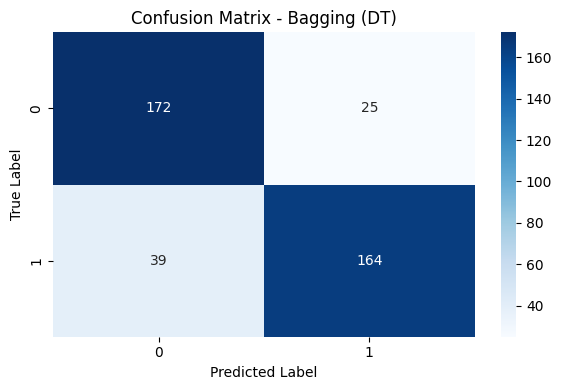

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Bagging with SVC Performance Metrics:
Accuracy: 0.8725
Precision: 0.8725
Recall: 0.8725
F1 Score: 0.8725


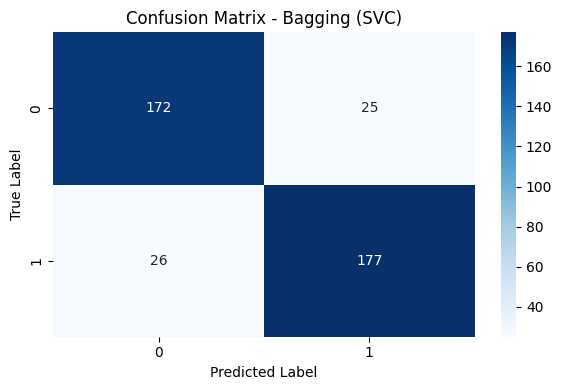

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



AdaBoost Classifier Performance Metrics:
Accuracy: 0.8050
Precision: 0.8050
Recall: 0.8051
F1 Score: 0.8050


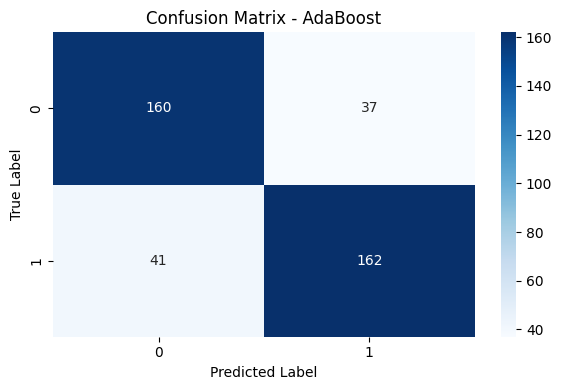


Gradient Boosting Classifier Performance Metrics:
Accuracy: 0.8525
Precision: 0.8528
Recall: 0.8527
F1 Score: 0.8525


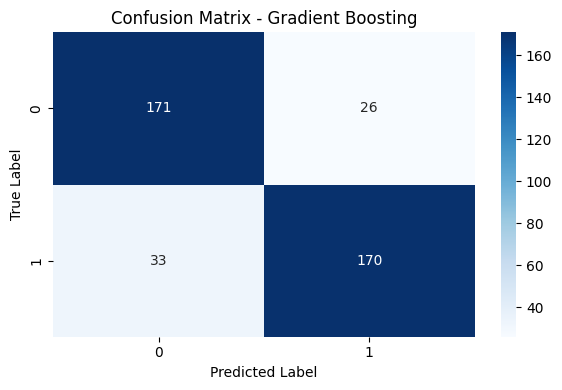

Training rf for custom ensemble...
Training xgb for custom ensemble...
Training lgb for custom ensemble...
Model weights for custom ensemble: [0.33397964 0.33325254 0.33276781]

Custom Ensemble Classifier Performance Metrics:
Accuracy: 0.8175
Precision: 0.8187
Recall: 0.8179
F1 Score: 0.8174


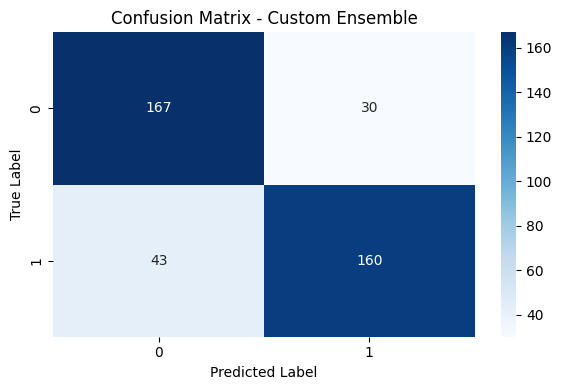


=== Model Comparison ===
                   accuracy  precision    recall  f1_macro
nb                   0.8750   0.874972  0.874972  0.874972
mlp                  0.8750   0.874972  0.874972  0.874972
bagging_svc          0.8725   0.872462  0.872509  0.872480
svc                  0.8700   0.869971  0.869971  0.869971
advanced_stacking    0.8650   0.865416  0.865270  0.864997
knn                  0.8650   0.864972  0.865045  0.864986
lr                   0.8600   0.861978  0.859443  0.859649
soft_voting          0.8550   0.855192  0.855192  0.855000
weighted_voting      0.8525   0.853043  0.852804  0.852492
gradient_boosting    0.8525   0.852791  0.852729  0.852499
hard_voting          0.8525   0.853043  0.852804  0.852492
catboost             0.8400   0.840680  0.840339  0.839984
bagging_dt           0.8400   0.841445  0.840489  0.839936
basic_stacking       0.8275   0.828697  0.827949  0.827447
rf                   0.8250   0.826869  0.825561  0.824891
lgb                  0.8250   

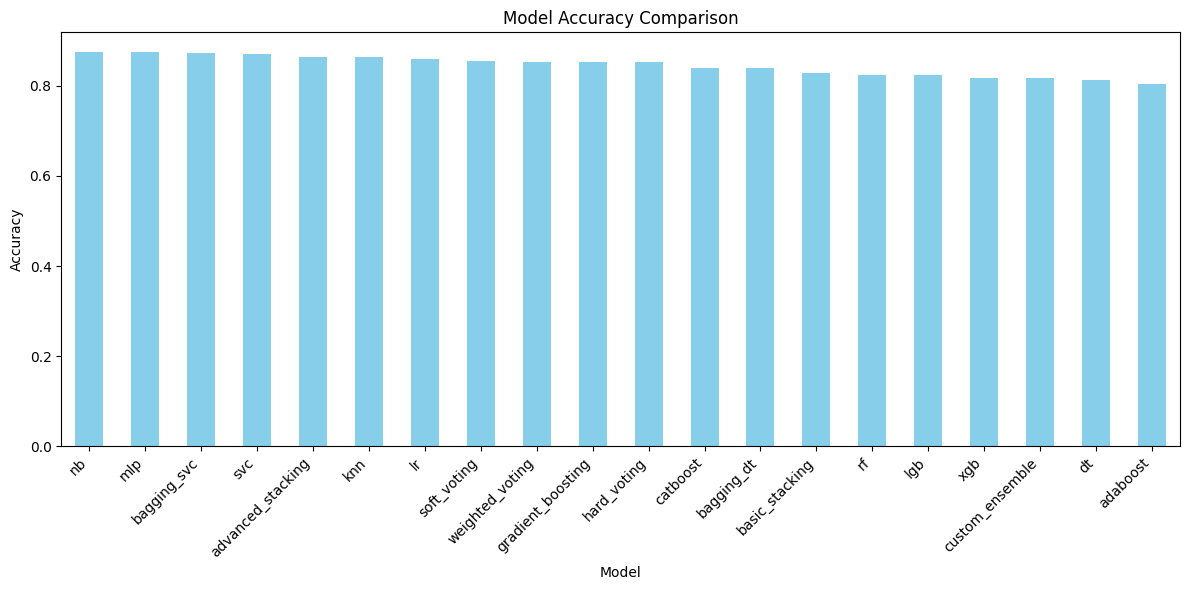

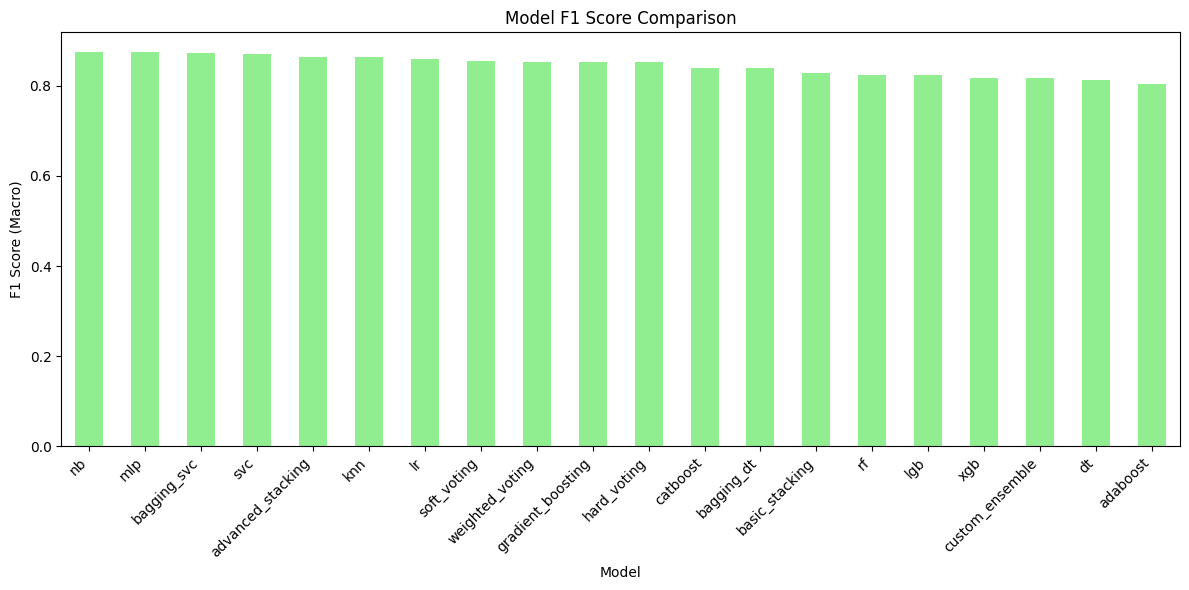


Best performing model: nb
Best model performance: accuracy     0.875000
precision    0.874972
recall       0.874972
f1_macro     0.874972
Name: nb, dtype: float64


In [27]:
if __name__ == "__main__":
    X, y = data.drop('label',axis=1), data.label
    
    # Instantiate and run the experiments
    experiment = EnsembleExperiments(X, y)
    experiment.run_all_experiments()